In [ ]:
# !apt-get install openslide-tools
# !pip install openslide-python
# !pip install opencv-python

# Applied Deep Learning Project 
## Camylon16 challenge

In [1]:
import tensorflow as tf
tf.enable_eager_execution()

!sudo rm -f /etc/boto.cfg
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
import train_test_save
import loading_data

In [2]:
## Must be openslide version 3.4.1
from openslide import open_slide, __library_version__ as openslide_version
print(openslide_version)
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1"

3.4.1


# Defining the slides we are using for test and train. 

We are training on three slides  : []

We are testing on three slides : []


In [3]:
## Optional: remove sliced images from directory if necessary
!rm -r 'data'

rm: cannot remove 'data': No such file or directory


## Defining the levels we are using : 1,3,5

In [3]:
level = [1,3,5]

## Defining the images we are training and testing on

In [4]:
training_image_path_list = ['tumor_075.tif',
                            'tumor_084.tif',
                           'tumor_091.tif']

## If the files aren't uploaded to GCP instance, then use the code below to download the image and mask tif files.

In [9]:
for each in training_image_path_list: 
    each = each.split('.')[0]
    get_ipython().system('gsutil cp  gs://adl-bucket/' + each + '_mask.tif '+ each + '_mask.tif')
    get_ipython().system('gsutil cp  gs://adl-bucket/' + each +'.tif ' + each  + '.tif')

for each in testing_image_path_list: 
    each = each.split('.')[0]
    get_ipython().system('gsutil cp  gs://adl-bucket/' + each + '_mask.tif '+ each + '_mask.tif')
    get_ipython().system('gsutil cp  gs://adl-bucket/' + each +'.tif ' + each  + '.tif')


### Here we are processing the images and segmenting the images for first level we are using .

In [6]:
with tf.device('/cpu:0'):
    train_test_save.train_part_1(training_image_path_list[0], num_pixels = 64, num_level = level[0])

tumor_075.tif tumor_075_mask.tif


In [7]:
with tf.device('/cpu:0'):
    train_test_save.train_part_1(training_image_path_list[1], num_pixels = 64, num_level = level[0])

tumor_084.tif tumor_084_mask.tif


In [10]:
with tf.device('/cpu:0'):
    train_test_save.train_part_1(training_image_path_list[2], num_pixels = 64, num_level = level[0])

tumor_091.tif tumor_091_mask.tif


### Here we are processing the images and segmenting the images for second level we are using .

In [12]:
with tf.device('/cpu:0'):
    train_test_save.save_second_level(training_image_path_list, input_level = level[0], num_input_pixels = 64, 
                                                       output_level = level[1], num_output_pixels = 64)

### Here we are processing the images and segmenting the images for third level we are using .

In [13]:
with tf.device('/cpu:0'):
    train_test_save.save_second_level(training_image_path_list, input_level = level[0], num_input_pixels = 64, 
                                                       output_level = level[2], num_output_pixels = 64)

## Here we are creating train dataset from the three levels. 

In [5]:
with tf.device('/cpu:0'):
    ds_train, steps_per_epoch_train = loading_data.train_part(training_image_path_list,
                                                                num_level_1 = level[0],
                                                                num_level_2 = level[1],
                                                                num_level_3 = level[2])

In [6]:
print(steps_per_epoch_train)

4360


## Defining the VGG tower model we are using. It takes three inputs, each corresponding to the same segment in different zoom levels. 

## We are using zoom levels 1, 3, and 5.

In [7]:
## Imagenet bases using model subclassing
class dense_conv_split_model(tf.keras.Model):

    def __init__(self):
        super(dense_conv_split_model, self).__init__(name='dense_conv_split_model')

        conv_base = tf.keras.applications.VGG16(weights='imagenet',include_top=False) 
            
            
        conv_base.trainable = False

        self.cnn1 = conv_base
        self.model1_flatten1  = tf.keras.layers.Flatten()

        self.cnn2 = conv_base
        self.model2_flatten2 = tf.keras.layers.Flatten()

        self.cnn3 = conv_base
        self.model3_flatten3 = tf.keras.layers.Flatten()


        self.merge_layer = tf.layers.Dense(128, activation='relu')
        self.dropout = tf.layers.Dropout(0.5)
        self.dense1 = tf.layers.Dense(16, 'relu')

        self.final = tf.layers.Dense(2, activation='softmax')

    def call(self, x):
        x1, x2, x3 = x[0], x[1], x[2]

        x1 = self.cnn1(x1)
        x1 = self.model1_flatten1(x1)

        x2 = self.cnn2(x2)
        x2 = self.model2_flatten2(x2)
        
        x3 = self.cnn3(x3)
        x3 = self.model3_flatten3(x3)


        x = tf.concat([x1, x2, x3], 1)
        x = self.merge_layer(x)
        x = self.dropout(x)
        x = self.dense1(x)
        x = self.final(x)

        return x

In [8]:
model = dense_conv_split_model()

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
## Compile and train model
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss=tf.keras.losses.sparse_categorical_crossentropy, 
              metrics = ['acc'])

history = model.fit(ds_train, epochs=10, steps_per_epoch=steps_per_epoch_train, verbose=1)

Epoch 1/10
4360/4360 [==============================] - 117s 27ms/step
Epoch 2/10
4360/4360 [==============================] - 102s 23ms/step
Epoch 3/10
4360/4360 [==============================] - 102s 23ms/step
Epoch 4/10
4360/4360 [==============================] - 102s 23ms/step
Epoch 5/10
4360/4360 [==============================] - 102s 23ms/step
Epoch 6/10
4360/4360 [==============================] - 102s 23ms/step
Epoch 7/10
4360/4360 [==============================] - 102s 23ms/step
Epoch 8/10
4360/4360 [==============================] - 102s 23ms/step
Epoch 9/10
4360/4360 [==============================] - 102s 23ms/step
Epoch 10/10
4360/4360 [==============================] - 102s 23ms/step


### Saving and loading the model weights

In [13]:
model.save_weights('weights/new_weights_final')
# model.load_weights('weights/new_weights_final.h5')

Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than manually editing the Checkpoint proto.


In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
flatten_3 (Flatten)          multiple                  0         
_________________________________________________________________
flatten_4 (Flatten)          multiple                  0         
_________________________________________________________________
flatten_5 (Flatten)          multiple                  0         
_________________________________________________________________
dense_4 (Dense)              multiple                  3145856   
_________________________________________________________________
dropout_2 (Dropout)          multiple                  0         
_________________________________________________________________
dense_5 (Dense)              multiple                  2064      
__________

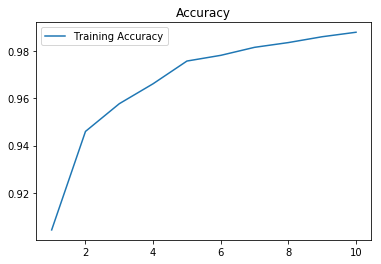

In [12]:
## Plot results
acc = history.history['acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training Accuracy')
plt.title('Accuracy')
plt.legend()


plt.show()

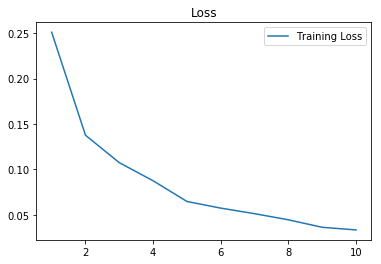

In [13]:
loss = history.history['loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training Loss')
plt.title('Loss')
plt.legend()


plt.show()

# Validation

In [10]:
def evaluate(image_path):
    #Loading image slide at first level.
    image_depth, image_width, tumor_mask, tissue_regions, slide_image_test = train_test_save.test_part_1(image_path,
                                                                                                     num_pixels=64,
                                                                                                     num_level = level[0])
    # Loading image slide at second level.                                                                                                 
    train_test_save.load_second_level(image_path,
                                  input_level = level[0],
                                  num_input_pixels = 64,
                                  output_level = level[1],
                                  num_output_pixels = 64)
                                                                                                     
    # Loading image slide at third level.                                                                                            
    train_test_save.load_second_level(image_path,
                                  input_level = level[0],
                                  num_input_pixels = 64,
                                  output_level = level[2],
                                  num_output_pixels = 64)

    # This function creates a dataset from the three levels the test image is segmented at. Then it predicts, and 
    # prints precision , recall, F1, confusion matrix and the generated hea                                                                                                 
    loading_data.test_part(image_path,
                                model,
                                tissue_regions,
                                slide_image_test,
                                tumor_mask,
                                image_depth,
                                image_width,
                                num_level_1 = level[0], 
                                num_level_2 = level[1],
                                num_level_3 = level[2])

### Defining path of image tif files for those files we will test on

In [13]:
testing_image_path_list = ['tumor_110.tif', 'tumor_101.tif', 'tumor_096.tif', 'tumor_075.tif']

## Evaluating on slide 1 

tumor_110.tif tumor_110_mask.tif
Slide image
Predicted image
Actual mask
ROC AUC score:  0.9013598994152591
              precision    recall  f1-score   support

           0       0.85      0.98      0.91 261054827
           1       0.98      0.82      0.89 247227245

   micro avg       0.90      0.90      0.90 508282072
   macro avg       0.92      0.90      0.90 508282072
weighted avg       0.91      0.90      0.90 508282072



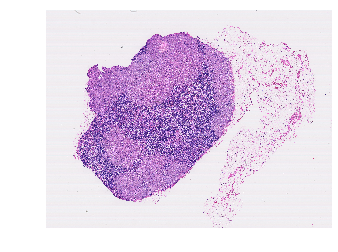

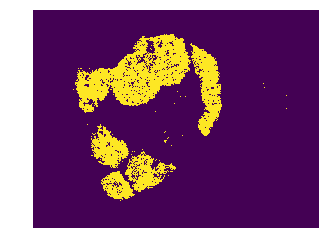

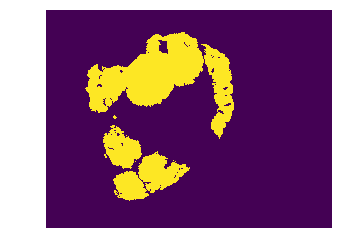

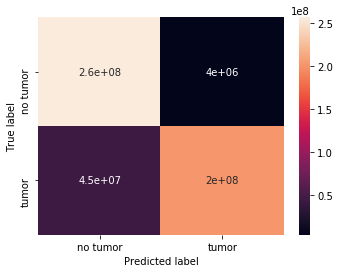

In [20]:
with tf.device('/cpu:0'):    
    evaluate(testing_image_path_list[0])

## Evaluating on slide 2 

tumor_101.tif tumor_101_mask.tif
Slide image
Predicted image
Actual mask
ROC AUC score:  0.560891140145724
              precision    recall  f1-score   support

           0       1.00      0.13      0.22 491317391
           1       0.10      1.00      0.18  46266139

   micro avg       0.20      0.20      0.20 537583530
   macro avg       0.55      0.56      0.20 537583530
weighted avg       0.92      0.20      0.22 537583530



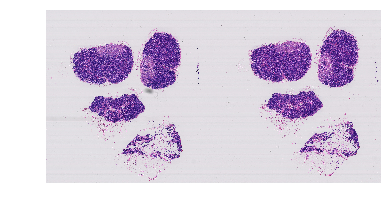

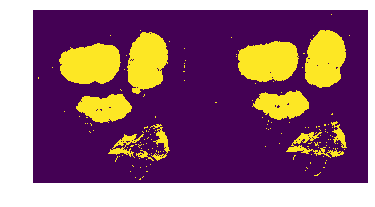

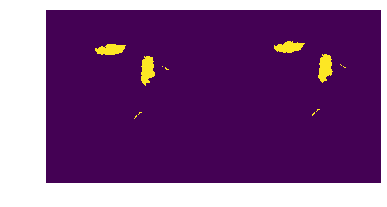

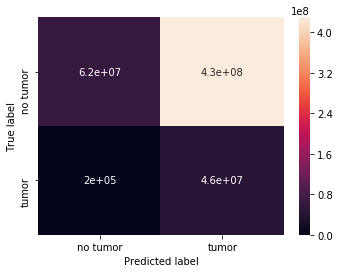

In [18]:
with tf.device('/cpu:0'):    
    evaluate(testing_image_path_list[1])

## Evaluating on slide 3

tumor_096.tif tumor_096_mask.tif
Slide image
Predicted image
Actual mask
ROC AUC score:  0.8662605524602267
              precision    recall  f1-score   support

           0       1.00      0.95      0.98 398316870
           1       0.18      0.78      0.29   5084806

   micro avg       0.95      0.95      0.95 403401676
   macro avg       0.59      0.87      0.63 403401676
weighted avg       0.99      0.95      0.97 403401676



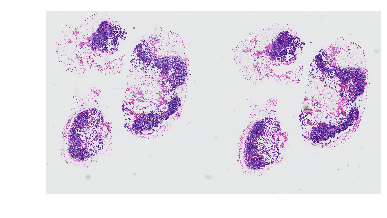

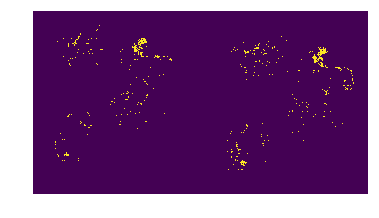

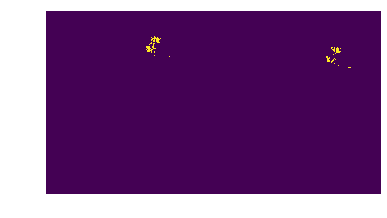

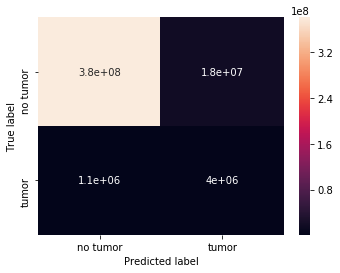

In [12]:
with tf.device('/cpu:0'):    
    evaluate(testing_image_path_list[2])

## Evaluating Slide 4

In [ ]:
with tf.device('/cpu:0'):    
    evaluate(testing_image_path_list[3])

tumor_075.tif tumor_075_mask.tif
